# Purpose of the notebook

It's a notebook for developing and demonstrating functions for detecting and removing artifacts.

In [18]:
import sys

sys.path.insert(
    1, "..\\utilities\\"
)  # adds utilities folder to path so we can import modules from it, won't be needed after packaging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import loading_utils as load
import preprocessing_utils as prep

participant_list = [200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 213]
data_dir = './results/new/'

In [19]:
# This is a block for making participant dataframes from raw files in directory data_dir (here Windows path to retinawise mirror folder on drive)
# It saves the participant dfs into directory defined in save_path (about 300 - 400 MB per participant), format 2xx_recording_data.csv
# Uncomment and run if you don't have these dataframes (remember that the folder specified in save_path must exist)
# data_dir = "D:/retinawise_mirror/raw/"
# save_path = './results/'
# for participant_id in participant_list:
#     data_df, protocol_timecourse_df, protocol_vars_df = load.load_participant_data(participant_no=participant_id,
#                                                                                    data_dir=data_dir,
#                                                                                    include_failed=False,
#                                                                                    save=True,
#                                                                                    save_path=save_path)

# General notes

Artifacts can be found through searching for datapoints where pupil size is out of physiological ranges or has a sudden change in value. I will perform this on non-resampled data, since then we will avoid the extreme values being included in bins for resampling. Physiological ranges are between 2 and 8 mm, some sources also give 1.5 - 9 mm, e.g. https://link.springer.com/article/10.3758/s13428-018-1075-y. In accord with this article, measurements outside of this range should be set to NaN.

# Removal of samples outside of physiological range

In [20]:
def remove_non_physio_size(data_df):
    data_df.loc[(data_df['Stim eye - Size Mm']<1.5) | (data_df['Stim eye - Size Mm']>9), 'Stim eye - Size Mm'] = pd.NA
    return data_df

In [21]:
data_dir = "./results/new/"  
data_suffix = "_recording_data.csv" 

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

MemoryError: Unable to allocate 150. MiB for an array with shape (22, 892375) and data type float64

In [ ]:
data_df = remove_non_physio_size(data_df)

# MAD based artifact detection

For MAD based detection as described here: https://pmc.ncbi.nlm.nih.gov/articles/PMC6538573/, I need to calculate dilation/constriction speed of the pupil. Thanks to that, artifacts related e.g. to blinking can be found through the MAD estimator. In my view, this method should be applied on resampled data - thanks to that the velocity calculation window is constant in sampling time and it avoids the issue when sometimes the time difference between samples was equal to 0, resulting in infinite speed.

In [22]:

def compute_pupil_speed_mad(resampled_df, multiplier=3):
    resampled_df['Constriction speed'] = pd.Series()
    resampled_df['MAD threshold'] = pd.Series()
    for recording_id in sorted(resampled_df['Recording id'].unique()):
        trial = resampled_df[resampled_df['Recording id']==recording_id].copy()
        trial['Time diff'] = trial['Trial time Sec'].diff()
        trial['Size diff'] = trial['Stim eye - Size Mm'].diff()
        trial.loc[trial['Time diff']<0,'Size diff'] = pd.NA
        trial.loc[trial['Time diff']<0,'Time diff'] = pd.NA
        
        trial['Constriction speed -1'] = abs(trial['Size diff']/trial['Time diff'])
        trial['Constriction speed +1']=abs(trial['Size diff'].shift(1)/trial['Time diff'].shift(1))
        trial['Constriction speed']=trial[['Constriction speed -1','Constriction speed +1']].max(axis='columns')
        median = trial['Constriction speed'].median()
        mad = (abs(trial['Constriction speed'] - median)).median()
        threshold = multiplier*mad
        resampled_df.loc[resampled_df['Recording id']==recording_id,'Constriction speed'] = trial['Constriction speed']
        resampled_df.loc[resampled_df['Recording id']==recording_id,'MAD threshold'] = threshold
    return resampled_df
        


In [23]:
data_dir = "./results/resampled/"  # directory with resampled data
data_suffix = "_nonan_30_resampled_data.csv"  # name of file with 30 Hz resampled data from participant 2xx, name format: 2xxdata_suffix

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

In [24]:
data_df = remove_non_physio_size(data_df)
data_df = compute_pupil_speed_mad(data_df,multiplier=3)

In [25]:
data_df['Trial no'][data_df['Constriction speed']>8]

10978      20.0
10979      20.0
42242      75.0
42243      75.0
60298     106.0
60299     106.0
77814     137.0
77815     137.0
88662     156.0
88663     156.0
100684    177.0
100685    177.0
102921    181.0
102922    181.0
105281    185.0
105282    185.0
105284    185.0
105285    185.0
105286    185.0
105287    185.0
112030    197.0
112031    197.0
141996    250.0
141997    250.0
158175    278.0
158176    278.0
158181    278.0
158182    278.0
161019    283.0
161020    283.0
171323    301.0
171324    301.0
171362    301.0
171363    301.0
172509    303.0
172510    303.0
192989    339.0
192990    339.0
201690    354.0
201691    354.0
202104    355.0
202105    355.0
206808    363.0
206809    363.0
207216    364.0
207217    364.0
212943    374.0
212944    374.0
232580    409.0
232581    409.0
247772    435.0
247773    435.0
259176    455.0
259177    455.0
Name: Trial no, dtype: float64

Text(0.5, 0, 'Time [s]')

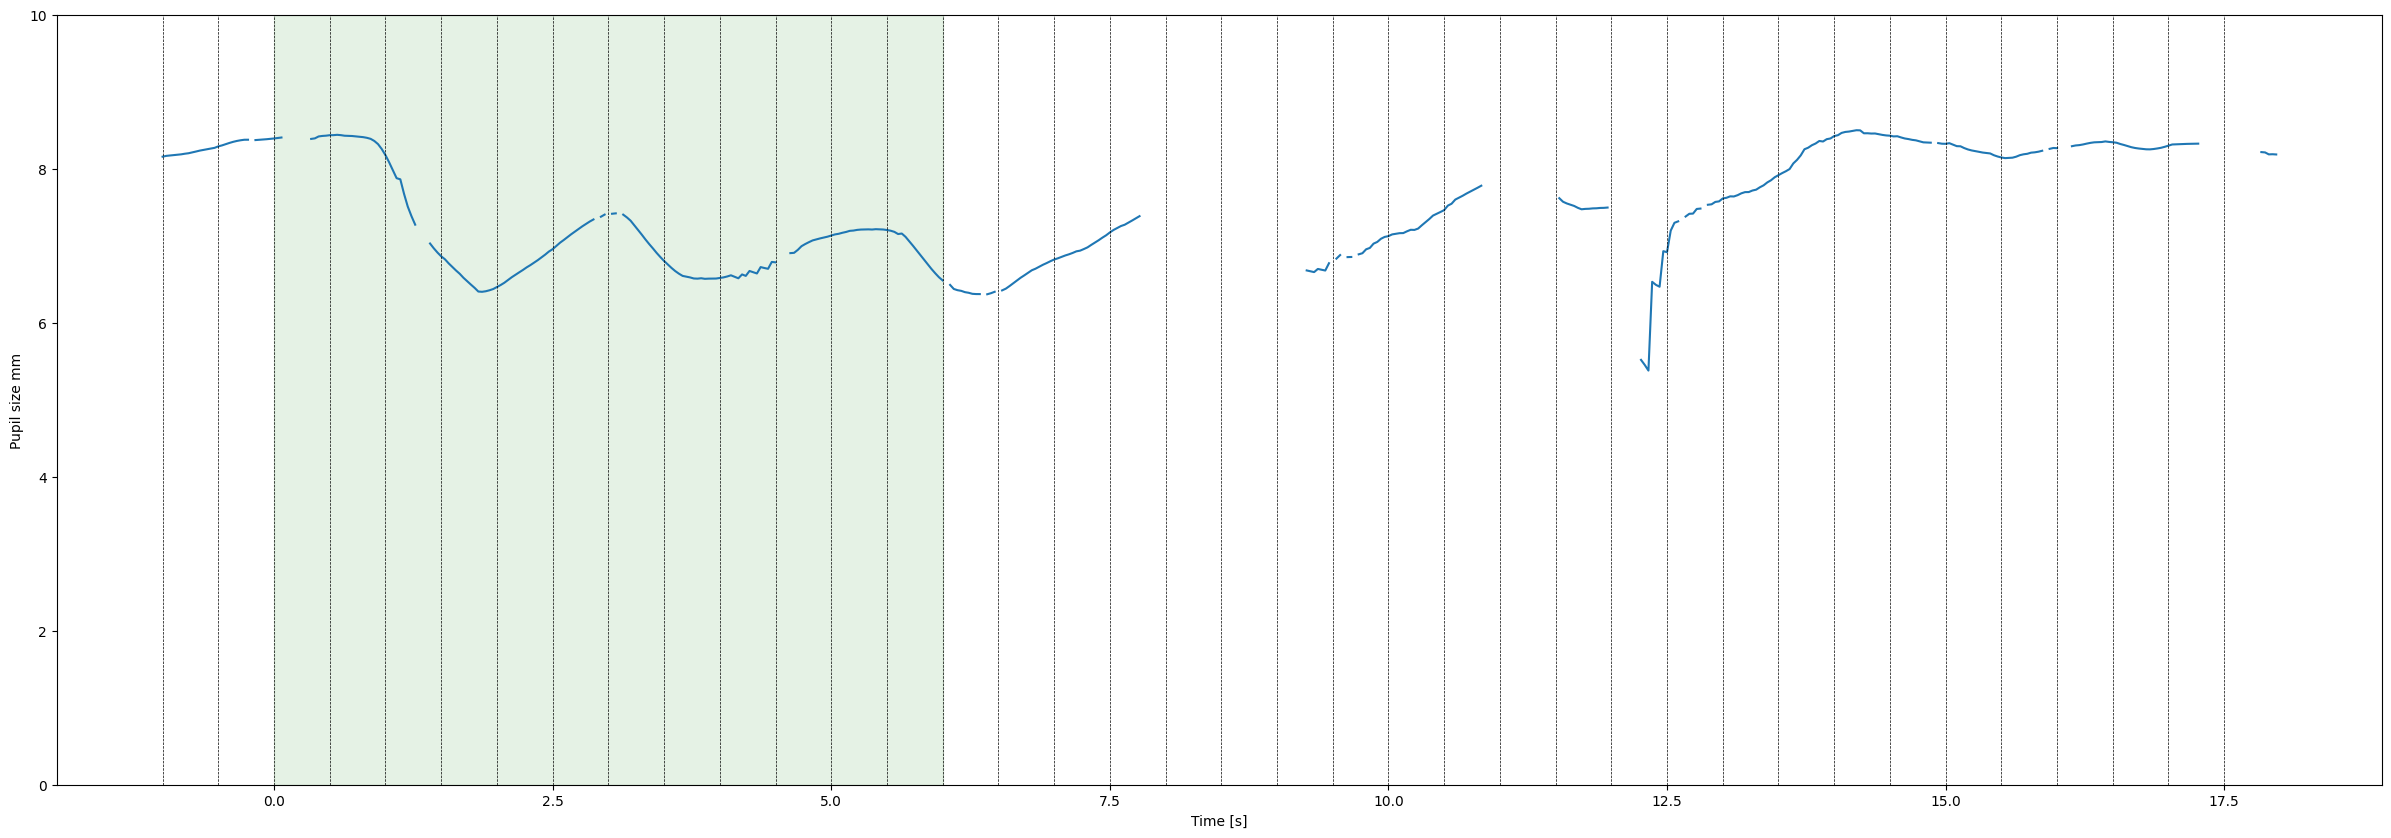

In [26]:
plt.figure(figsize = (30,10))

#plt.plot(data_df['Trial time Sec'][data_df['Trial no']==185],data_df['Constriction speed'][data_df['Trial no']==185],label='speed mm/s')
plt.plot(data_df['Trial time Sec'][data_df['Trial no']==185],data_df['Stim eye - Size Mm'][data_df['Trial no']==185])
#plt.plot(data_df['Trial time Sec'][data_df['Trial no']==185],data_df['MAD threshold'][data_df['Trial no']==185],label='mad threshold')
plt.ylabel('Pupil size mm')
plt.ylim([0,10])
for i in np.arange(-1,18,0.5):
    plt.axvline(i,c='k',lw=0.5,ls='--')
plt.axvspan(0, 6, alpha=0.1, color="green")
plt.xlabel('Time [s]')

<Axes: ylabel='Constriction speed'>

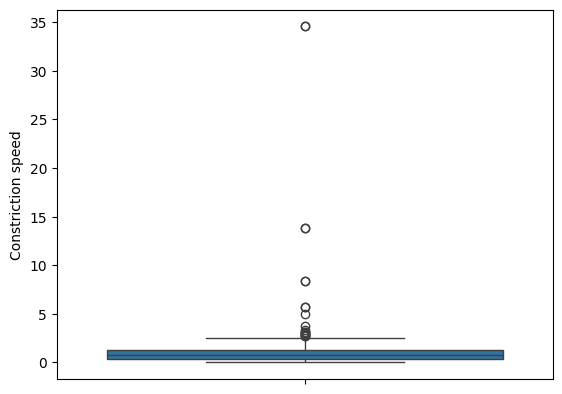

In [27]:
sns.boxplot(data_df.loc[(data_df['Trial no']==185)&(data_df['Trial time Sec']>1),'Constriction speed'])


In [28]:
from scipy import signal

In [29]:
data_df_filtered = data_df.copy(deep=True)

In [30]:
data_df_filtered['Stim eye - Size Mm'] = data_df_filtered['Stim eye - Size Mm'].interpolate('cubicspline')

In [31]:
[b,a] = signal.butter(N = 2, Wn=10,btype='lowpass',fs=30)


In [32]:
data_df_filtered['Stim eye - Size Mm'] = signal.filtfilt(b=b,a=a,x=data_df_filtered['Stim eye - Size Mm'])

In [33]:
data_df

,Unnamed: 0,Trial time datetime,Stim eye - Size Mm,Trial time Sec,Trial no,Trial type,Block,Test,Recording id,Eye,Participant id,Trial phase,Constriction speed,MAD threshold
0,0,-1 days +23:59:59,8.41547,-1.000000,1.0,lms,0,b,1,R,201,pre-stim,NaN,0.96031
1,1,-1 days +23:59:59.033333334,8.42239,-0.966667,1.0,lms,0,b,1,R,201,pre-stim,0.207602,0.96031
2,2,-1 days +23:59:59.066666668,8.43141,-0.933334,1.0,lms,0,b,1,R,201,pre-stim,0.270603,0.96031
3,3,-1 days +23:59:59.100000002,8.44198,-0.900000,1.0,lms,0,b,1,R,201,pre-stim,0.317094,0.96031
4,4,-1 days +23:59:59.133333336,8.45506,-0.866667,1.0,lms,0,b,1,R,201,pre-stim,0.392404,0.96031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299245,299245,0 days 00:00:17.833333710,6.01270,17.833333,525.0,flux,10,b,22,R,201,post-stim,0.521405,0.867609
299246,299246,0 days 00:00:17.866667044,6.03140,17.866667,525.0,flux,10,b,22,R,201,post-stim,0.560989,0.867609
299247,299247,0 days 00:00:17.900000378,6.05144,17.900000,525.0,flux,10,b,22,R,201,post-stim,0.601206,0.867609
299248,299248,0 days 00:00:17.933333712,6.07841,17.933333,525.0,flux,10,b,22,R,201,post-stim,0.809108,0.867609


In [34]:
data_df = compute_pupil_speed_mad(data_df_filtered,multiplier=3)

Text(0.5, 0, 'Time [s]')

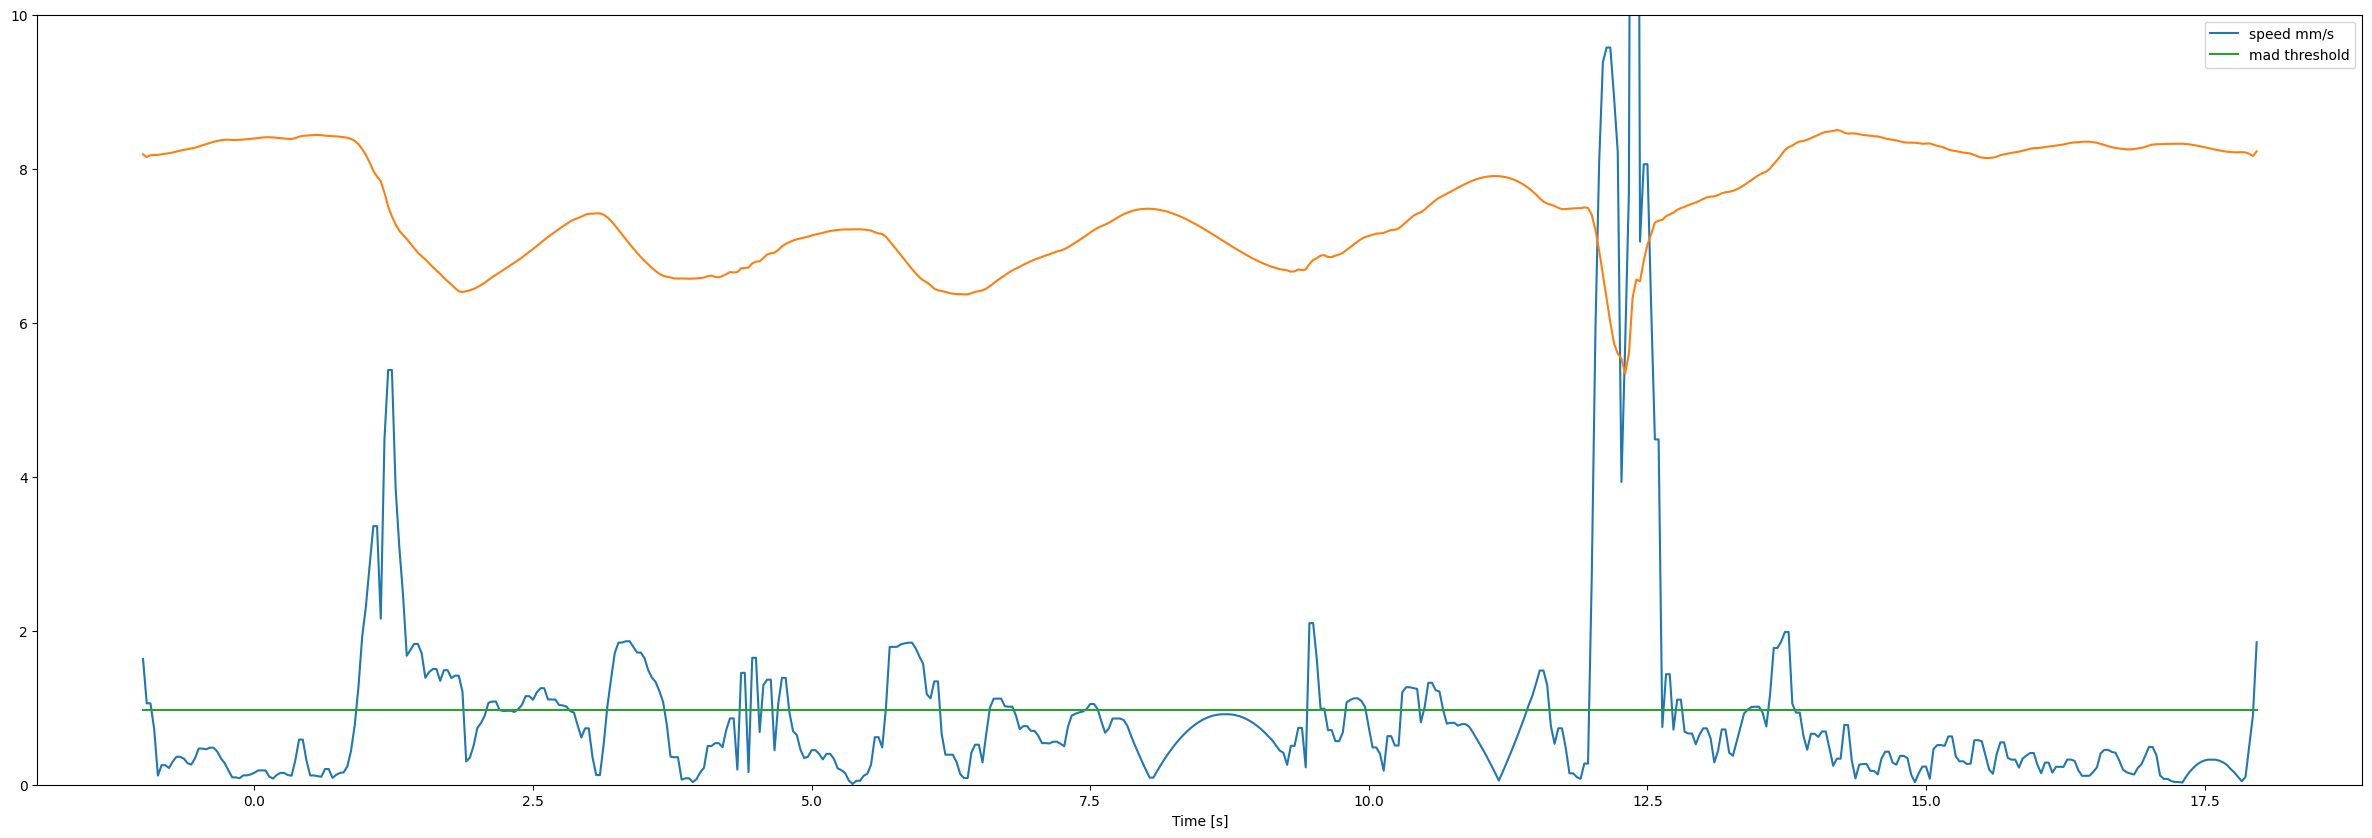

In [35]:
plt.figure(figsize = (30,10))

plt.plot(data_df['Trial time Sec'][data_df['Trial no']==185],data_df['Constriction speed'][data_df['Trial no']==185],label='speed mm/s')
plt.plot(data_df['Trial time Sec'][data_df['Trial no']==185],data_df['Stim eye - Size Mm'][data_df['Trial no']==185])
plt.plot(data_df['Trial time Sec'][data_df['Trial no']==185],data_df['MAD threshold'][data_df['Trial no']==185],label='mad threshold')
plt.legend()
plt.ylim([0,10])
plt.xlabel('Time [s]')